# Grover Search Algorithm

Reference: This notebook is a modified version of the tutorial from IBM found at [here](https://learning.quantum.ibm.com/tutorial/grovers-algorithm)

## Background


Amplitude amplification is a general purpose quantum algorithm, or subroutine, that can be used to obtain a quadratic speedup over a handful of classical algorithms. [Grover’s algorithm](https://arxiv.org/abs/quant-ph/9605043) was the first to demonstrate this speedup on unstructured search problems. Formulating a Grover's search problem requires an oracle function that marks one or more computational basis states as the states we are interested in finding, and an amplification circuit that increases the amplitude of marked states, consequently suppressing the remaining states.

Here, we demonstrate how to construct Grover oracles and use the `GroverOperator` from the Qiskit circuit library to easily set up a Grover's search instance. The runtime `Sampler` primitive allows seamless execution of Grover circuits.


## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime (`pip install qiskit-ibm-runtime`) 0.22 or later


In [1]:
%pip install 'qiskit[visualization]'
%pip install qiskit_ibm_runtime
%pip install qiskit_aer
%pip install matplotlib
%pip install pylatexenc
%pip install qiskit-transpiler-service

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.7 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=99b14879597bc294b49db9ebb4b09caf7f2d4d6529c906b2b958bdf37d70061d
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

## Setup

Let's import the necessary modules for this tutorial:


In [2]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

## Step 1: Map classical inputs to a quantum problem

Grover's algorithm requires an [oracle](https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm) that specifies one or more marked computational basis states, where "marked" means a state with a phase of -1.  A controlled-Z gate, or its multi-controlled generalization over $N$ qubits, marks the $2^{N}-1$ state (`'1'`\*$N$ bit-string).  Marking basis states with one or more `'0'` in the binary representation requires applying X-gates on the corresponding qubits before and after the controlled-Z gate; equivalent to having an open-control on that qubit.  In the following code, we define an oracle that does just that, marking one or more input basis states defined through their bit-string representation.  The `MCMT` gate is used to implement the multi-controlled Z-gate.


In [3]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

### Specific Grover's instance

Now that we have the oracle function, we can define a specific instance of Grover search.  In this example we will mark two computational states out of the eight available in a three-qubit computational space:


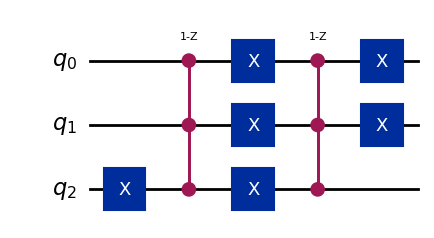

In [4]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

### GroverOperator

The built-in Qiskit `GroverOperator` takes an oracle circuit and returns a circuit that is composed of the oracle circuit itself and a circuit that amplifies the states marked by the oracle.  Here, we `decompose` the circuit to see the gates within the operator:


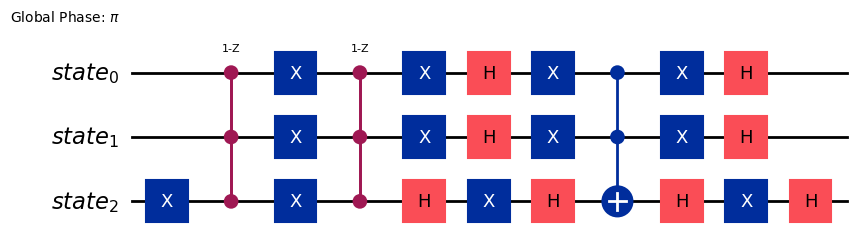

In [5]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Repeated applications of this `grover_op` circuit amplify the marked states, making them the most probable bit-strings in the output distribution from the circuit.  There is an optimal number of such applications that is determined by the ratio of marked states to total number of possible computational states:


In [6]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

### Full Grover circuit

A complete Grover experiment starts with a Hadamard gate on each qubit; creating an even superposition of all computational basis states, followed the Grover operator (`grover_op`) repeated the optimal number of times.  Here we make use of the `QuantumCircuit.power(INT)` method to repeatedly apply the Grover operator.


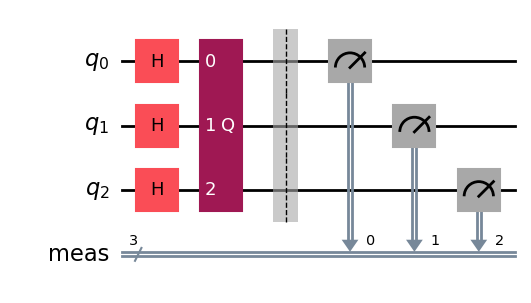

In [7]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

## Step 2: Optimize problem for quantum execution


In [8]:
backend = AerSimulator()

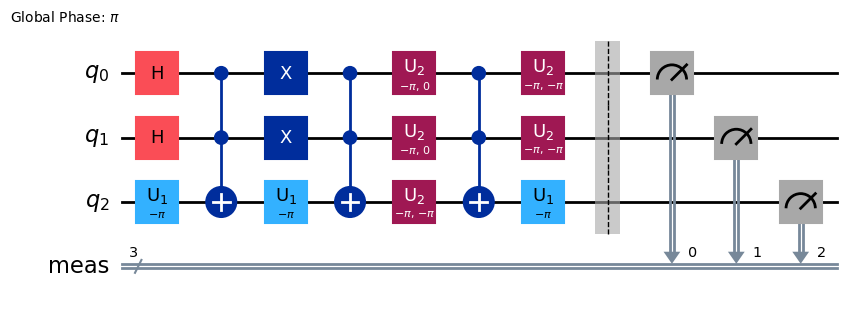

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

## Step 3 & 4: Execute the circuit and analyze outcome

Qiskit offers a range of simulators that model different quantum errors present in real devices. Let's compare two types of simulators: one that provides ideal, noise-free output, and another that incorporates realistic noise models to simulate the behavior of actual quantum hardware.

### (a) Ideal, noise-free simulator

Measurement outcomes: {'011': 505, '100': 495}


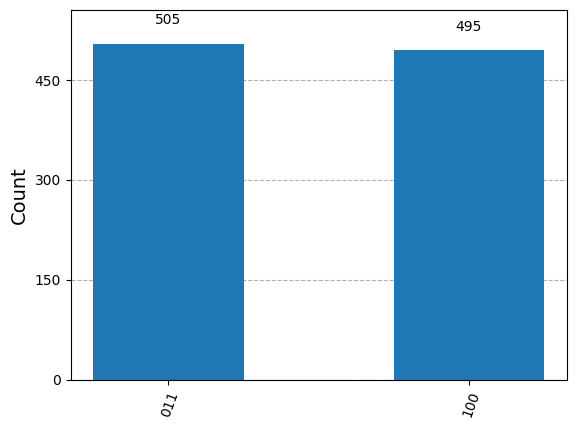

In [10]:
# run the simulation 1000 times
qc_compiled = transpile(circuit_isa, backend)
job = backend.run(qc_compiled, shots=1000)

result = job.result()
counts = result.get_counts(qc_compiled)
print("Measurement outcomes:", counts)
plot_histogram(counts)

As shown, the noise free simulator produced our marked states '011' and '100' correctly with nearly equal probability.

Let's see what a noisy simulator will generate.



### (b) Noisy simulator

Measurement outcomes: {'000': 47, '010': 40, '001': 32, '110': 49, '101': 44, '100': 361, '111': 46, '011': 381}


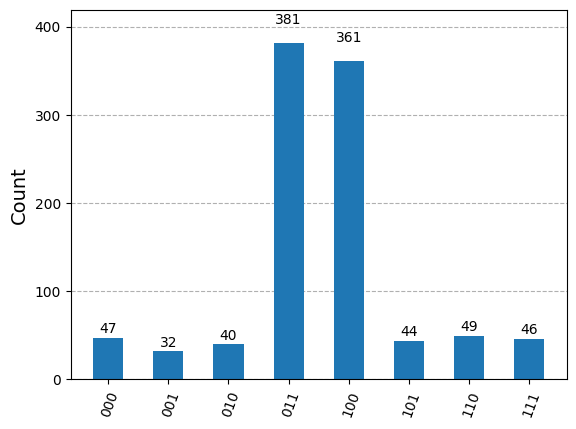

In [11]:
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
device_backend = FakeVigoV2()
sim_vigo = AerSimulator.from_backend(device_backend)

# run the simulation 1000 times
qc_compiled_noisy = transpile(circuit_isa, sim_vigo)
job = sim_vigo.run(qc_compiled_noisy, shots=1000)

result = job.result()
counts = result.get_counts(0)
print("Measurement outcomes:", counts)
plot_histogram(counts)

We now observe that the marked states '011' and '100' still have the highest probabilities, however we now see that other states also appear in our measurements. This shows real quantum devices are subject to noise and errors and may potentially affect the performance of algorithm.

Congratulations on completing this lab on Grover's algorithm using the Qiskit workflow! 🎉

Throughout this exercise, you've gained hands-on experience in constructing a Grover oracle, building the full search circuit, and running it on both ideal and noisy backends.

We hope this lab has strengthened your quantum programming skills and deepened your appreciation for the balance between theoretical quantum algorithms and the realities of current quantum hardware as well as the importance of error mitigation strategies in practical quantum computing.

Thank you for completing this tutorial and keep that quantum momentum going! ✌